## Eksplorativna i statistička analiza novosadskih kompanija prema zvaničnim podacima iz finansijskih izveštaja za 2024. godinu

Ova analiza predstavlja eksplorativni i statistički pregled poslovanja aktivnih društava sa ograničenom odgovornošću (DOO) sa sedištem u Novom Sadu, zasnovan na finansijskim izveštajima za 2024. godinu. Izvor podataka je Agencija za privredne registre (APR), a analiza obuhvata isključivo jednu kalendarsku godinu i jednu geografsku lokaciju, zbog čega vremenska i prostorna dimenzija nisu predmet razmatranja.

Obuhvaćeni su kvantitativni i kvalitativni pokazatelji poslovanja preduzeća, uz korišćenje atributa poput prihoda, neto dobiti, broja zaposlenih, bonitetne ocene i drugih relevantnih podataka. Na osnovu njih razvijeni su dodatni finansijski pokazatelji – poput profitnih i operativnih marži, prihoda po zaposlenom i pokazatelja koji posredno ukazuju na nivo kapitalnih ulaganja – koji omogućavaju identifikaciju obrazaca i razlika u poslovanju između sektora i pojedinačnih kompanija.

Cilj analize je da se stekne uvid u strukturu, snagu i karakteristike tržišta Novog Sada, kao i da se identifikuju ključni faktori koji oblikuju njegovu ekonomsku dinamiku.

In [2658]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

from scipy.stats import zscore, f_oneway
from sklearn.linear_model import LinearRegression

pd.set_option("display.float_format", "{:.2f}".format)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Podaci o novosadskim kompanijama prema podacima iz finansijskih izveštaja za 2024. godinu.

In [2659]:
df = pd.read_parquet("data/novi_sad_2024.parquet")

DataFrame šifara i opisa delatnosti srpske privrede.

In [2660]:
delatnosti_df = pd.read_parquet("data/delatnosti.parquet")

### 1. OSNOVNE INFORMACIJE O DATASETU

In [2661]:
df.shape

(3327, 23)

In [2662]:
df.isna().sum()

MB                   0
PIB                  0
Datum osnivanja      0
Naziv preduzeća      0
Mesto                0
                  ... 
Ebit (EUR)           0
Ebitda (EUR)         0
Email               98
Zastupnik            3
PDV Obveznik       833
Length: 23, dtype: int64

In [2663]:
df.columns

Index(['MB', 'PIB', 'Datum osnivanja', 'Naziv preduzeća', 'Mesto',
       'Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik',
       'Šifra delatnosti', 'Naziv delatnosti', 'APR Status', 'NBS Status',
       'Bonitetna ocena', 'Veličina', 'Promet (EUR)', 'Neto dobit (EUR)',
       'Broj zaposlenih', 'Ebit (EUR)', 'Ebitda (EUR)', 'Email', 'Zastupnik',
       'PDV Obveznik'],
      dtype='object')

### 2. ČIŠĆENJE PODATAKA

Postupak pripreme podataka:
- 2.A Uklonjene su kolone koje sadrže kontakt informacije i podaci koji nisu relevantni za analizu.
- 2.B Izbrisana su dva zapisa kod kojih veličina preduzeća nije određena.
- 2.C Preimenovanje kolona radi lakšeg pozivanja i obrade atributa.
- 2.D Svođenje delatnosti na sektor i industrijski nivo.
- 2.E Uklonjene su kompanije sa prijavljenim prihodom od 0.
- 2.F Uklonjene su kompanije bez zaposlenih.
- 2.G Datum osnivanja konvertovan je u godinu, a dodat je i atribut dekade osnivanja.

2.A Uklonjene su kolone koje sadrže kontakt informacije i podaci koji nisu relevantni za analizu.i.

In [2664]:
columns_to_remove = [
    'MB', 'PIB','Mesto','Poštanski broj', 'Adresa', 'Telefon', 'Pravni oblik','Naziv delatnosti', 'APR Status', 'NBS Status','Email', 'Zastupnik',
       'PDV Obveznik']

df_cleaned = df.drop(columns=columns_to_remove)

2.B Izbrisana su dva zapisa kod kojih veličina preduzeća nije određena.

In [2665]:
df_cleaned = df_cleaned[df_cleaned['Veličina'].notna()]

2.C Preimenovanje kolona radi lakšeg pozivanja i obrade atributa.

In [2666]:
columns_rename_map = {
    "Datum osnivanja": "godina_osnivanja",
    'Naziv preduzeća': 'naziv',
    'Šifra delatnosti':'sifra_delatnosti',
    'Bonitetna ocena':'bonitet',
    'Veličina': 'velicina',
    'Promet (EUR)': 'prihod',
    'Neto dobit (EUR)': 'neto_dobit',
    'Broj zaposlenih': 'broj_zaposlenih',
    'Ebit (EUR)': 'ebit',
    'Ebitda (EUR)': 'ebitda'
}

df_cleaned = df_cleaned.rename(columns=columns_rename_map)

delatnosti_df = delatnosti_df.rename(columns={'CODE':'sifra','LAT': 'opis'})

df_cleaned.columns

Index(['godina_osnivanja', 'naziv', 'sifra_delatnosti', 'bonitet', 'velicina',
       'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda'],
      dtype='object')

2.D Svođenje delatnosti na sektor i industrijski nivo.

In [2667]:
# Dodavanje vodeće nule ako je potrebno
df_cleaned['sifra_delatnosti'] = df_cleaned['sifra_delatnosti'].astype(str).str.zfill(4)

# Svođenje delatnosti na sektor i industrijski nivo
df_cleaned['sektor'] = df_cleaned['sifra_delatnosti'].str[:2]
df_cleaned.rename(columns={'sifra_delatnosti': 'industrija'}, inplace=True)

2.E Uklonjene su kompanije sa prijavljenim prihodom od 0.

In [2668]:
df_cleaned = df_cleaned[df_cleaned['prihod'] > 0]

2.F Uklonjene su kompanije bez zaposlenih.

In [2669]:
df_cleaned = df_cleaned[df_cleaned['broj_zaposlenih'] > 0]

2.G Datum osnivanja konvertovan je u godinu, a dodat je i atribut dekade osnivanja.

In [2670]:
df_cleaned['godina_osnivanja'] = pd.to_datetime(df_cleaned['godina_osnivanja'], format='%d.%m.%Y').dt.year
df_cleaned['dekada_osnivanja'] = (df_cleaned['godina_osnivanja'] // 10) * 10

In [2671]:
df_cleaned.sample(n=5, random_state=42)

,godina_osnivanja,naziv,industrija,bonitet,velicina,prihod,neto_dobit,broj_zaposlenih,ebit,ebitda,sektor,dekada_osnivanja
1720,2003,PROOF-CLEAN,4743,C2,Mikro,18595,-41199,1,-11955,-11819,47,2000
200,2016,SYNERGY AGRO DOO NOVI SAD,0146,C1,Malo,2055789,35721,4,172943,196265,01,2010
244,1987,PSS POLJOPRIVREDNA STANICA DOO NOVI SAD,7219,B1,Malo,1574030,176011,42,218613,262752,72,1980
2401,2020,NOBU TECHWAY,7311,D3,Mikro,63778,811,5,-6964,-3512,73,2020
1710,2024,MARHI CUBE DOO,7112,B1,Mikro,19988,7887,1,9280,9280,71,2020


### 3. KONSTRUKCIJA DODATNIH KARAKTERISTIKA (feature engineering)

Postupak:
- 3.A Izračunavanje operativnih rashoda
- 3.B Izračunavanje vrednosti amortizacije
- 3.C Izračunavanje profitnih marži (neto marža, EBIT marža, EBITDA marža)
- 3.D Izračunavanje marže amortizacije
- 3.E Izračunavanje marže kamata i poreza

In [2672]:
df_features = df_cleaned.copy().reset_index()
del df_cleaned

#### 3.A Izračunavanje operativnih rashoda

Operativni rashodi predstavljaju ukupne troškove poslovanja koji nastaju tokom osnovne poslovne aktivnosti, bez uzimanja u obzir amortizacije, kamata i poreza. Izračunavaju se kao razlika između prihoda i EBITDA. Omogućavaju detaljniji uvid u troškove koji se direktno odnose na proizvodne i operativne procese. Upoređujući operativne rashode među različitim kompanijama, možemo steći uvid u efikasnost njihovih operacija i način upravljanja troškovima.

In [2673]:
df_features['operativni_rashodi'] = round(df_features.prihod - df_features.ebitda, 2)

#### 3.B. Vrednost amortizacije

Amortizacija predstavlja raspodelu troška kapitalnih ulaganja kroz vreme i obuhvata smanjenje vrednosti dugoročne imovine. Izračunava se kao razlika između EBITDA i EBIT, međutim, važno je napomenuti da vrednost amortizacije ne ukazuje direktno na visinu kapitalnih ulaganja, jer zavisi od primenjenih metoda amortizacije i korišćenja različitih amortizacionih stopa. Analizirajući vrednost amortizacije, možemo dobiti okvirnu informaciju o kapitalnoj intenzivnosti poslovanja kompanije i uočiti kako njena ulaganja u imovinu utiču na finansijske performanse. Upoređujući amortizaciju među kompanijama ili sektorima, moguće je primetiti razlike u pristupima kapitalnim ulaganjima, kao i njihovim efektima na profitabilnost.

In [2674]:
df_features['amortizacija'] = round(df_features.ebitda - df_features.ebit, 2)

#### 3.C. Marže

##### 3.C.1. Neto marža

Neto marža pokazuje koliko profita ostaje od svakih 100 jedinica prihoda nakon što se oduzmu svi troškovi, porezi i kamate. Upoređujući neto marže između kompanija, možemo utvrditi koja je kompanija efikasnija u konverziji prihoda u čist profit.

In [2675]:
df_features['net_marza'] = round(df_features.neto_dobit / df_features.prihod, 2)

##### 3.C.2. EBIT marža

EBIT marža pokazuje koliko od svaka 100 jedinica prihoda ostaje nakon operativnih troškova, pre kamata i poreza. Viša EBIT marža pokazuje da je kompanija efikasnija u generisanju profita iz osnovne delatnosti.

In [2676]:
df_features['ebit_marza'] = round(df_features.ebit / df_features.prihod, 2)

##### 3.C.3. EBITDA marža

Upoređivanje EBITDA marže pomaže u proceni koja kompanija ima bolju osnovnu operativnu efikasnost, pre nego što se oduzmu negotovinski troškovi kao što je amortizacija. Ovo je posebno korisno za upoređivanje kompanija sa različitim strukturama kapitala ili onih koje posluju u industrijama koje zahtevaju velika ulaganja u opremu, infrastrukturu i dugoročne resurse, kao što su industrija proizvodnje, energetika, telekomunikacije i građevina.

In [2677]:
df_features['ebitda_marza'] = round(df_features.ebitda / df_features.prihod, 2)

##### 3.C.4. Marža amortizacije

Razlika između EBITDA i EBIT, izražena kao procenat prihoda, pokazuje koliki deo ostvarenog prihoda se troši na amortizaciju osnovnih sredstava. Ova marža daje uvid u stepen zavisnosti poslovanja od dugotrajne imovine, poput opreme, mašina i objekata. Viša marža ukazuje na kapitalno intenzivnije poslovanje i veća ulaganja u imovinu koja se vremenom troši.

In [2678]:
df_features['marza_amortizacije'] = round((df_features.ebitda - df_features.ebit) / df_features.prihod * 100, 2)

##### 3.C.5. Marža kamata i poreza

Razlika između EBIT-a i neto profita pokazuje koliki iznos prihoda se troši na kamate i poreze. Ovaj podatak može pružiti uvid u finansijsko i poresko opterećenje poslovanja. Veći iznosi mogu ukazivati na veće dugove ili viši poreski teret, što utiče na konačnu profitabilnost. Međutim, rezultati ove analize treba da se uzmu sa rezervom, jer se ne može direktno izračunati nivo zaduženosti preduzeća, a razlika može biti pod uticajem različitih računovodstvenih metoda.

Ipak, posredno, ovakva marža može ukazivati na intenzitet zaduženosti sektora, jer veće kamate i porezi često reflektuju veći nivo duga u odnosu na kapital. Ova analiza može pomoći u identifikaciji sektora sa većim ili manjim zaduženjem, ali samo kao okvirna procena.

In [2679]:
df_features['marza_kamate_poreza'] = round((df_features.ebit - df_features.neto_dobit) / df_features.prihod * 100, 2)

In [2680]:
df_features.columns

Index(['index', 'godina_osnivanja', 'naziv', 'industrija', 'bonitet',
       'velicina', 'prihod', 'neto_dobit', 'broj_zaposlenih', 'ebit', 'ebitda',
       'sektor', 'dekada_osnivanja', 'operativni_rashodi', 'amortizacija',
       'net_marza', 'ebit_marza', 'ebitda_marza', 'marza_amortizacije',
       'marza_kamate_poreza'],
      dtype='object')

### 4. EKSPLORATIVNA, STATISTIČKA ANALIZA I VIZUELIZACIJA REZULTATA

PRIPREMA PODATAKA

Napomena o interpretaciji rezultata: 
Sve analize u ovom projektu imaju za cilj da istraže povezanost između pojedinačnih poslovnih pokazatelja kompanija iz Novog Sada. Iako određeni rezultati pokazuju statistički značajne povezanosti, važno je naglasiti da ove analize ne određuju uzročno-posledične odnose, niti identifikuju presudne faktore. Prikazani rezultati pružaju uvid u obrasce koji zaslužuju dodatnu, dublju analizu, uključujući i druge finansijske, operativne i tržišne aspekte poslovanja.

Pored ograničenja u interpretaciji uzročno-posledičnih odnosa, važno je napomenuti da pojedine informacije nisu direktno dostupne u skupu podataka, već su izvedene na osnovu dostupnih finansijskih pokazatelja, zato njihovu tačnost treba tumačiti uslovno, imajući u vidu ograničenja izvora podataka.

Iznosi su u hiljadama RSD.

#### Sadržaj:

- 4.A PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI
    - 4.A.1 Prema veličini
    - 4.A.2 Prema bonitetu
    - 4.A.3 Prema dekadi osnivanja

- 4.B SEKTORI PRIVREDE
    - 4.B.1 Najzastupljeniji sektori novosadskih kompanija.
    - 4.B.2 Najzastupljeniji sektori novosadskih kompanija prema veličini kompanije. -------- PROVERI SUMNJIVO MI JE
    - 4.B.3 Sektori sa najvišim i najnižim prosečnim prihodima. 
    - 4.B.4 Sektori sa najvišim i najnižim prihodima po zaposlenom.
    - 4.B.5 Sektori sa najvišim i najnižim prosečnim operativnim rashodima.
    - 4.B.6 Najprofitabilniji i najmanje profitabilni sektori.
    - 4.B.7 Sektori sa najvišim i najnižim neto maržama. 
    - 4.B.8 Sektori sa najvišim i najnižom prosečnom amortizacijom.
    - 4.B.8 Poređenje profitabilnosti proizvodnih i uslužnih sektora -------------------- NIJE URADJENO
    - 4.B.10 Pregled informacija izabranog sektoru

- 4.C PRIHODI
    - 4.C.1. Distribucija prihoda -- kao normalna raspodela
    - 4.C.2. Prihodi prema veličini kompanije. -- OK - bar plot
    - 4.C.3. Distribucija prihoda kompanija prema veličini. -- Stripplot, scatter ili violin, radije neki gradijent u bojama gde je svaka boja veličina a gradient vrednost prihoda
    - 4.C.4. Prihodi prema broju zaposlenih. -- OK
    - 4.C.5. Povezanost između prihoda i broja zaposlenih -- ovde bih radije primenio neku statistiku koja mi govori koliko je pobećanje broja zaposlenih bilo učinkovito
    - 4.C.5. Analiza izolovanih slučajeva (outlier) ---- Sektor sa najvećim brojem outlier-a i njihovo prosečno odstupanje od proseka sektora.

- 4.D. Rashodi
    - 4.D.1. Distribucija rashoda
    - 4.D.2. Rashodi prema veličini kompanije. 
    - 4.D.3. Analiza izolovanih slučajeva (outlier)

- 4.E. Neto dobit
    - 4.E.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit
    - 4.E.5. Pregled 10 najprofitabilnijih novosadskih kompanija i sektor kom pripadaju
    - 4.E.3. Gradijentno grupisanje profitabilnosti i veličine kompanija
    - 4.C.3. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.

- 4.D. Amortizacija -- kao pokazatelj kapitalnih investiranja -- EBITDA = EBIT + Amortizacija + Deprecijacija
    - 4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu --- - Scatter plot: amortizacija vs prihod (log-skala ako ima outliera) i korelacija+
    - 4.D.2. Prosečan neto povraćaj na kapitalna ulaganja. KPI: neto_dobit / amortizacija
    - 4.D.3. Vrednost kapitalnih ulaganja po sektoru. --- da li je proizvodnja više kapitalno intenzivna od usluga

- E. Marže poslovanja
    - 4.E.1. Neto marža. dekada osnivanja, sektor i industrija poslovanja
    - 4.E.2. EBIT marža. veličina, bonitet, sektor i industrija poslovanja
    - 4.E.3. EBITDA marža: veličina, bonitet, sektor i industrija poslovanja
    - 4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja
    - 4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.
    - Marža kamate i poreza prema industriji poslovanja -- Koliko je kapitalno ulaganje vezano za industriji kompanije
    - Koji su najuticajniji faktori na vrednost neto marže (npr. veličina kompanije, sektor, kapitalna ulaganja, broj zaposlenih) -- Vizualizacija: Višestruki bar plot-ovi ili box plot-ovi za podelu po sektoru i veličini.

- F. Zaposleni
    - 4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.
    - 4.F.2. Test normalne distribucije zaposlenih po prihodima ------ Predlog: Kod “test normalnosti”, koristi histogram + Shapiro-Wilk test (ili Anderson-Darling), po grupama prihoda.
    - 4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.
    - 4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

- XXX. Ostalo Komparativna analiza 
    - performanse novih vs. starijih kompanija i vidiš kako se ponašaju po sektoru, veličini i bonitetu. Pomoću pair plots ili scatter matrix možeš vizualizovati ove komparativne analize.

- 4.H KLASTER ANALIZA


In [2681]:
df_analysis = df_features.copy()

#### 4.A. PREGLED DISTRIBUCIJE KOMPANIJA PO BROJČANOSTI

Ovim pregledima dobijamo uvid u brojčanu i strukturnu raspodelu kompanija u Novom Sadu. Prikazuje se kako su firme klasifikovane prema veličini, što otkriva zastupljenost mikro, malih, srednjih i velikih preduzeća u lokalnoj privredi. Analiza boniteta osvetljava finansijsku stabilnost firmi, dok raspodela po dekadama osnivanja pokazuje kada su nastajale kompanije,. Ukupno, ove analize služe kao polazna tačka za razumevanje poslovnog pejzaža grada.

4.A.1. Prema veličini

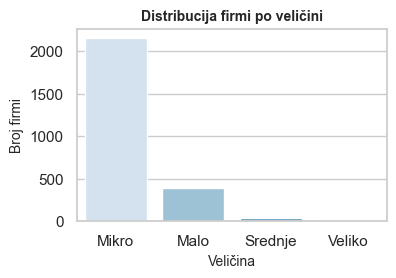

In [2682]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='velicina',
    palette='Blues',
    order=['Mikro', 'Malo', 'Srednje', 'Veliko'],
    legend=False
)

plt.title('Distribucija firmi po veličini', fontsize=10, fontweight='bold')
plt.xlabel('Veličina', fontsize=10)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

4.A.2. Prema bonitetu

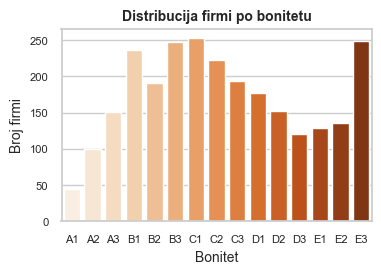

In [2683]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='bonitet',
    palette='Oranges',
    order=['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3', 'D1', 'D2', 'D3', 'E1', 'E2', 'E3'],
    legend=False
)

plt.title('Distribucija firmi po bonitetu', fontsize=10, fontweight='bold')
plt.xlabel('Bonitet', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

4.A.3. Prema dekadi osnivanja

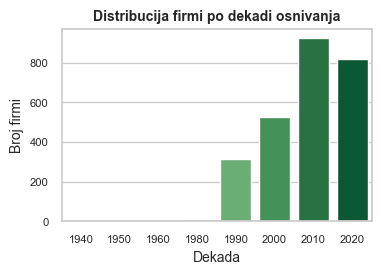

In [2684]:
plt.figure(figsize=(4, 2.5))
sns.countplot(
    data=df_analysis,
    x='dekada_osnivanja',
    palette='YlGn',
    legend=False
)

plt.title('Distribucija firmi po dekadi osnivanja', fontsize=10, fontweight='bold')
plt.xlabel('Dekada', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Broj firmi', fontsize=10)

plt.show()

#### 4.B. SEKTOR I INDUSTRIJA

Obrada podataka za analizu sektora

In [2685]:
#1. Sektor count
sektor_df = df_analysis['sektor'].value_counts().reset_index()

#2. Sektor opis
sektor_df = sektor_df.merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
sektor_df['opis'] = "(" + sektor_df['sektor']  +") " + sektor_df['opis'].str.split('[,;]').str[0]
sektor_df.drop(columns=['sifra'], inplace=True)

# 3. Ukupni prihodi
sektor_df['ukupni_prihod'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['prihod'].sum()
)

# 4. Prosečni prihodi
sektor_df['prosecni_prihod'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['prihod'].mean()
)

# 5. Zaposleni
sektor_df['broj_zaposlenih'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['broj_zaposlenih'].sum()
)

# 6. Prosečan prihod po zaposlenom
sektor_df['prihod_po_zaposlenom'] = sektor_df['ukupni_prihod'] / sektor_df['broj_zaposlenih']

# 7. Prosečni operativni rashodi
sektor_df['prosecni_operativni_rashodi'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['operativni_rashodi'].sum()
)

# 8. Neto dobit
sektor_df['neto_dobit'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['neto_dobit'].sum()
)

# 8. Neto marza
sektor_df['neto_marza'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['net_marza'].mean()
)

# 8. Amortizacija
sektor_df['amortizacija'] = sektor_df['sektor'].map(
    df_analysis.groupby('sektor')['amortizacija'].median()
)


sektor_df.sample(n=5, random_state=42)

,sektor,count,opis,ukupni_prihod,prosecni_prihod,broj_zaposlenih,prihod_po_zaposlenom,prosecni_operativni_rashodi,neto_dobit,neto_marza,amortizacija
22,25,22,(25) Proizvodnja metalnih proizvoda,6276668,285303.09,104,60352.58,5621358,385762,-0.01,3414.50
0,46,472,(46) Trgovina na veliko,1793179113,3799108.29,3469,516915.28,1740845080,26798143,-0.11,1696.00
49,27,6,(27) Proizvodnja električne opreme,229612858,38268809.67,4146,55381.78,212095723,9260375,0.00,3337.00
4,41,135,(41) Izgradnja zgrada,312310568,2313411.61,1318,236957.94,282739426,23536186,-0.04,2461.00
54,35,4,(35) Snabdevanje električnom energijom,811100,202775.00,9,90122.22,709124,-864276,-0.56,7772.50


4.B.1. Najzastupljeniji sektori novosadskih kompanija.

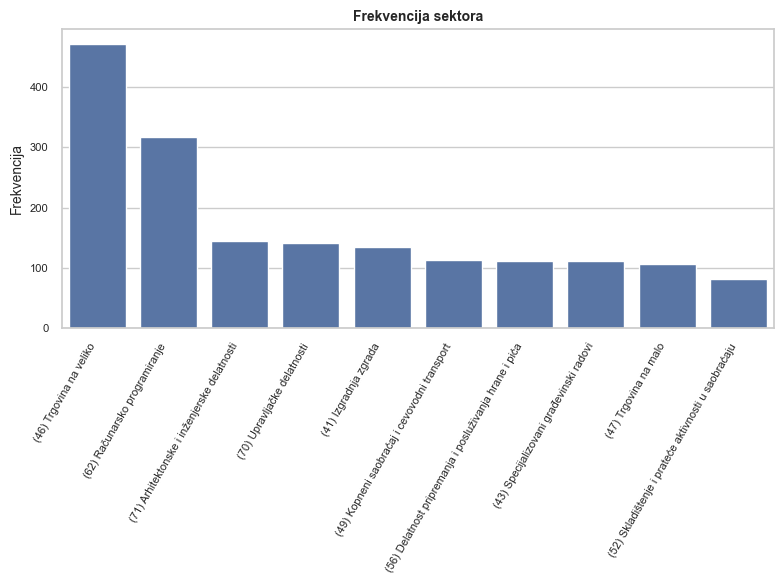

In [2686]:
sectors_count = sektor_df.head(10).reset_index(drop=True)
sectors_count


plt.figure(figsize=[8,6])

sns.barplot(data=sectors_count, x='opis', y='count')

plt.title('Frekvencija sektora', fontsize=10, fontweight='bold') 
plt.xlabel("")
plt.xticks(rotation=60, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.ylabel('Frekvencija', fontsize=10)
plt.tight_layout()  
plt.show()



4.B.2. Najzastupljeniji sektori novosadskih kompanija prema veličini kompanije.

In [2687]:
result = (
    df_analysis.groupby(['velicina', 'sektor'])
    .size()
    .reset_index(name='broj')
    .sort_values(['velicina', 'broj'], ascending=[True, False])
    .groupby('velicina')
    .first()
    .reset_index()
)

sektor_opisi = {
    šifra: opis.split(',')[0]
    for šifra, opis in zip(delatnosti_df['sifra'], delatnosti_df['opis'])
}

output_opis = {
    velicina: (sektor_opisi.get(sektor), broj)
    for velicina, sektor, broj in zip(result['velicina'], result['sektor'], result['broj'])
}

for velicina, (sektor_opis, broj) in output_opis.items():
    print(f"VELIČINA: {velicina}, NAJZASTUPLJENIJI SEKTOR: {sektor_opis}, BROJ: {broj}")

VELIČINA: Malo, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ: 96
VELIČINA: Mikro, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ: 363
VELIČINA: Srednje, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ: 10
VELIČINA: Veliko, NAJZASTUPLJENIJI SEKTOR: Trgovina na veliko, BROJ: 3


4.B.3. Sektori sa najvišim i najnižim prosečnim prihodima. 

Prikazuje sektore sa najvišim i najnižim prosečnim prihodima, omogućavajući uvid u to koje delatnosti generišu najveći obim poslovne aktivnosti. Za analizu je korišćena aritmetička sredina, što pruža jasniji prikaz prihoda i omogućava upoređivanje sektora na osnovu njihovog prihodnog potencijala.

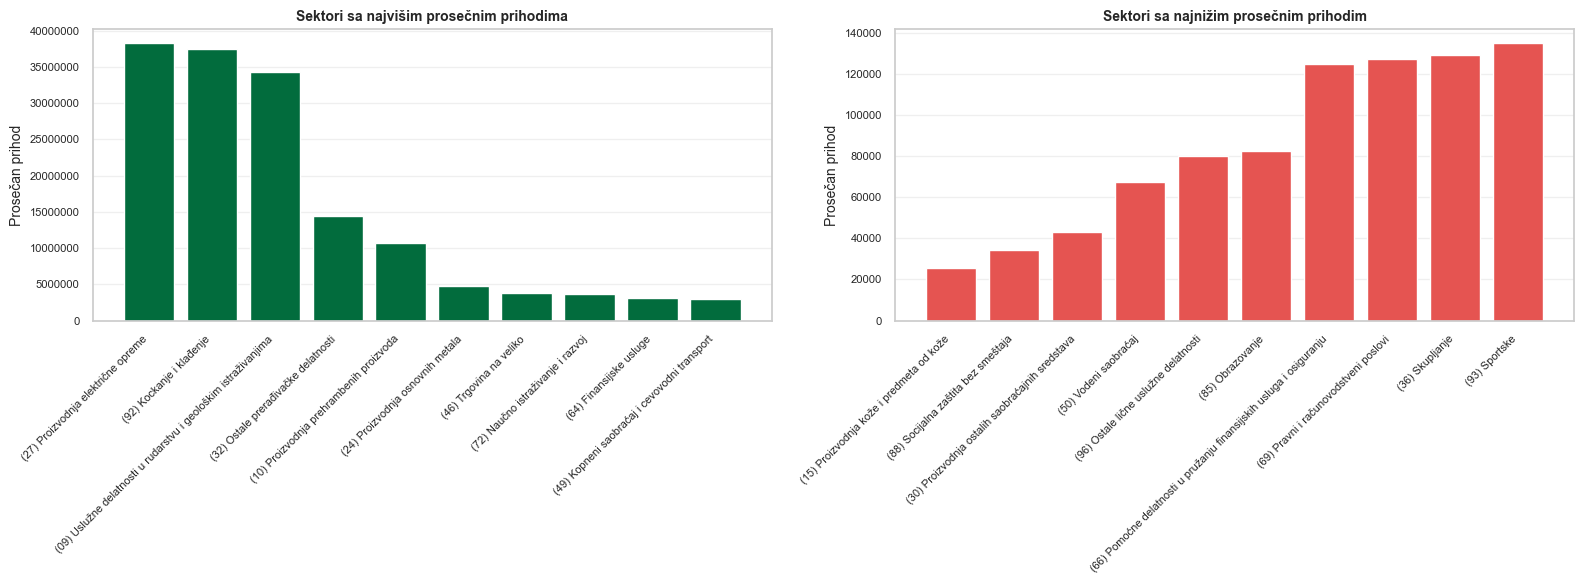

In [2694]:
top_revenue_sectors = sektor_df.sort_values('prosecni_prihod', ascending=False).head(10)
bottom_revenue_sectors = sektor_df.sort_values('prosecni_prihod', ascending=True).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_revenue_sectors['opis'], top_revenue_sectors['prosecni_prihod'], color='#026C3D')
ax1.set_title('Sektori sa najvišim prosečnim prihodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečan prihod', fontsize=10)
ax1.set_xticks(range(len(top_revenue_sectors['opis'])))
ax1.set_xticklabels(top_revenue_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_revenue_sectors['opis'], bottom_revenue_sectors['prosecni_prihod'], color='#E55451')
ax2.set_title('Sektori sa najnižim prosečnim prihodim', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečan prihod', fontsize=10)
ax2.set_xticks(range(len(bottom_revenue_sectors['opis'])))
ax2.set_xticklabels(bottom_revenue_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.4. Sektori sa najvišim i najnižim prihodima po zaposlenom.

Prikazuje efikasnost sektora kroz odnos ostvarenih prihoda i broja zaposlenih, odnosno koliko prihoduje prosečan zaposleni u određenom sektoru. Cilj je identifikovati sektore sa najvećom i najmanjom produktivnošću po zaposlenom.

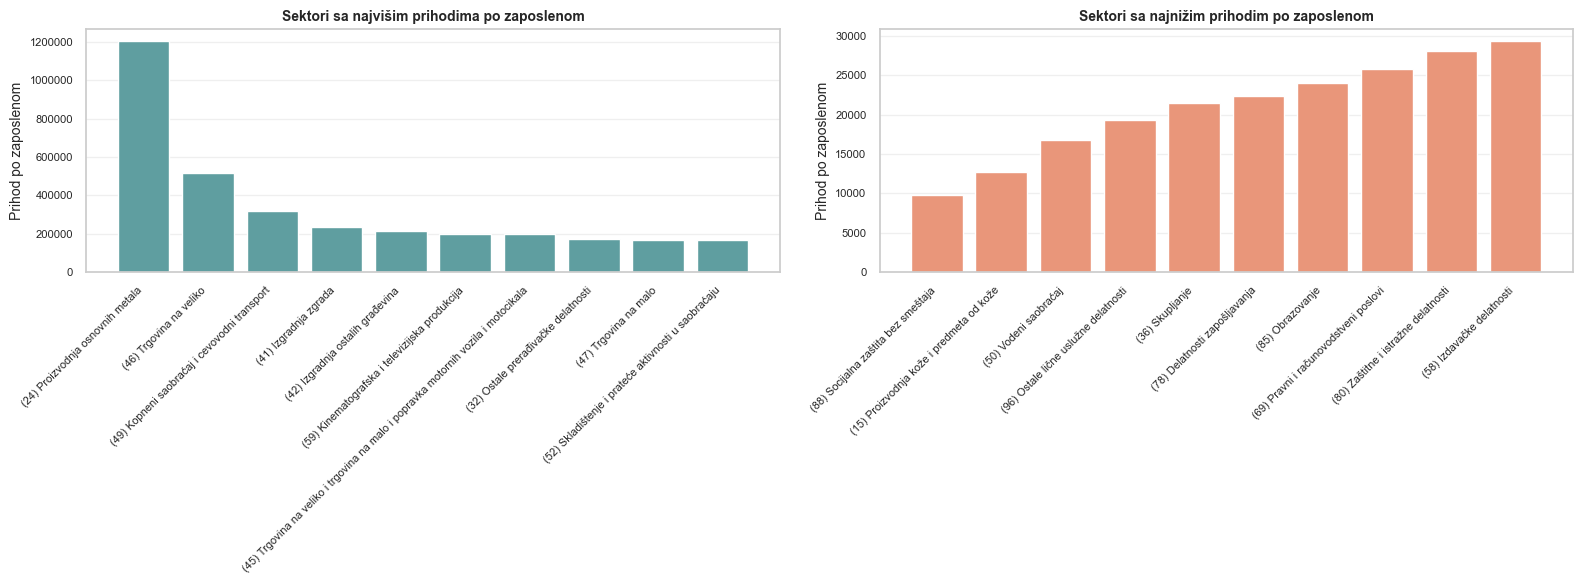

In [2693]:
top_rpe_sectors = sektor_df.sort_values('prihod_po_zaposlenom', ascending=False).head(10)
bottom_rpe_sectors = sektor_df.sort_values('prihod_po_zaposlenom', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_rpe_sectors['opis'], top_rpe_sectors['prihod_po_zaposlenom'], color='CadetBlue')
ax1.set_title('Sektori sa najvišim prihodima po zaposlenom', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prihod po zaposlenom', fontsize=10)
ax1.set_xticks(range(len(top_rpe_sectors['opis'])))
ax1.set_xticklabels(top_rpe_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_rpe_sectors['opis'], bottom_rpe_sectors['prihod_po_zaposlenom'], color='DarkSalmon')
ax2.set_title('Sektori sa najnižim prihodim po zaposlenom', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prihod po zaposlenom', fontsize=10)
ax2.set_xticks(range(len(bottom_rpe_sectors['opis'])))
ax2.set_xticklabels(bottom_rpe_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.5. Sektori sa najvišim i najnižim prosečnim operativnim rashodima.

Sektore sa najvišim i najnižim prosečnim operativnim rashodima, što omogućava uvid u efikasnost poslovanja u različitim delatnostima. Cilj je prepoznati oblasti sa visokim troškovima poslovanja i one koje ostvaruju veću operativnu efikasnost.

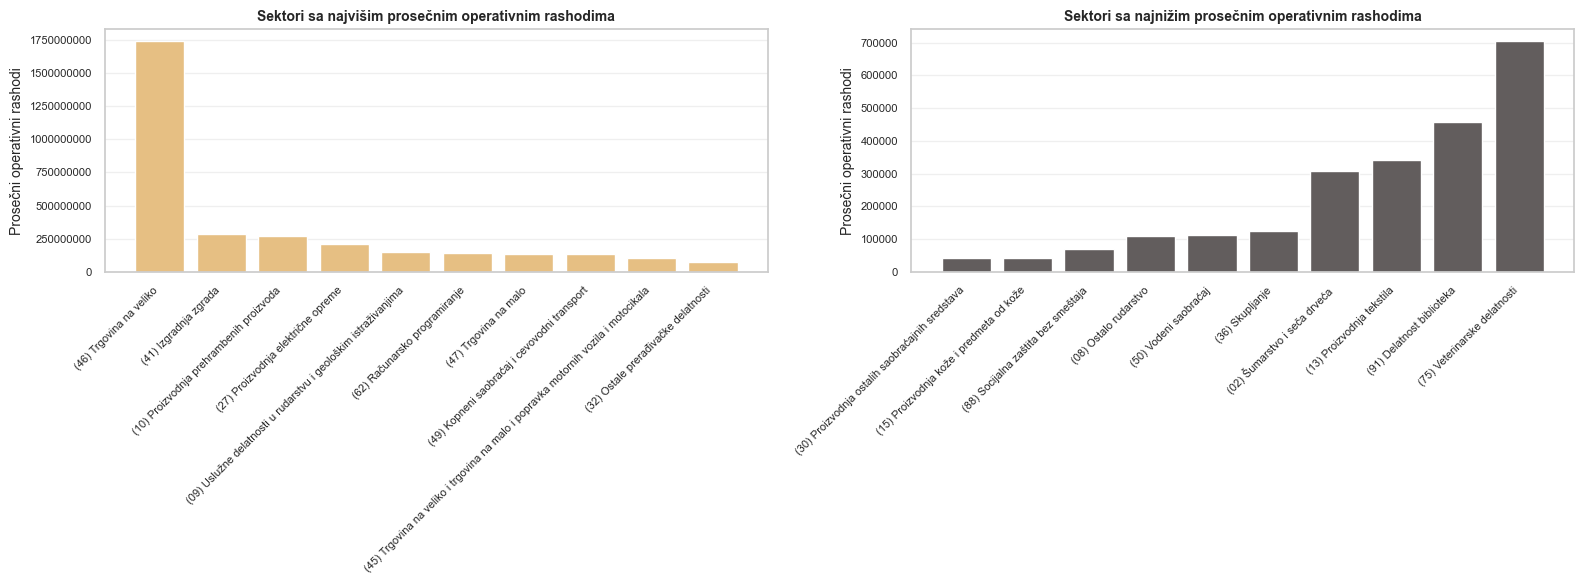

In [2700]:
top_rpexp_sectors = sektor_df.sort_values('prosecni_operativni_rashodi', ascending=False).head(10)
bottom_rpexp_sectors = sektor_df.sort_values('prosecni_operativni_rashodi', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_rpexp_sectors['opis'], top_rpexp_sectors['prosecni_operativni_rashodi'], color='#E6BF83')
ax1.set_title('Sektori sa najvišim prosečnim operativnim rashodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečni operativni rashodi', fontsize=10)
ax1.set_xticks(range(len(top_rpexp_sectors['opis'])))
ax1.set_xticklabels(top_rpexp_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_rpexp_sectors['opis'], bottom_rpexp_sectors['prosecni_operativni_rashodi'], color='#625D5D')
ax2.set_title('Sektori sa najnižim prosečnim operativnim rashodima', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečni operativni rashodi', fontsize=10)
ax2.set_xticks(range(len(bottom_rpexp_sectors['opis'])))
ax2.set_xticklabels(bottom_rpexp_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.6. Najprofitabilniji i najmanje profitabilni sektori.

Identifikuje najprofitabilnije i najmanje profitabilne sektore na osnovu neto dobiti, omogućavajući uvid u finansijsku uspešnost različitih sektora. 

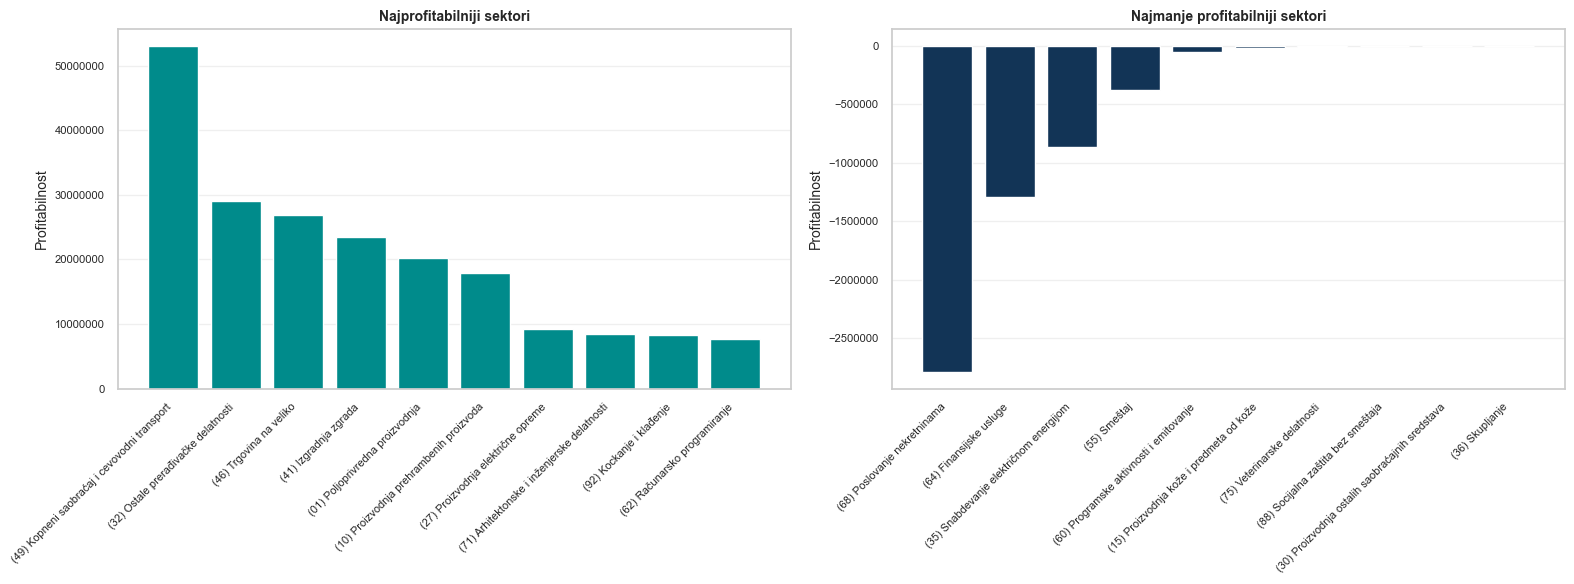

In [2703]:
top_nd_sectors = sektor_df.sort_values('neto_dobit', ascending=False).head(10)
bottom_nd = sektor_df.sort_values('neto_dobit', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_nd_sectors['opis'], top_nd_sectors['neto_dobit'], color='#008B8B')
ax1.set_title('Najprofitabilniji sektori', fontsize=10, fontweight='bold')
ax1.set_ylabel('Profitabilnost', fontsize=10)
ax1.set_xticks(range(len(top_nd_sectors['opis'])))
ax1.set_xticklabels(top_nd_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_nd['opis'], bottom_nd['neto_dobit'], color='#123456')
ax2.set_title('Najmanje profitabilniji sektori', fontsize=10, fontweight='bold')
ax2.set_ylabel('Profitabilnost', fontsize=10)
ax2.set_xticks(range(len(bottom_nd['opis'])))
ax2.set_xticklabels(bottom_nd['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.8. Sektori sa najvišim i najnižim prosečnim neto maržama. 

Prikazuje sektore sa najvišim i najnižim prosečnim neto maržama, pružajući uvid u profitabilnost različitih delatnosti. Ovaj pregled omogućava upoređivanje sektora na osnovu njihove sposobnosti da ostvaruju profit u odnosu na ukupne prihode, što je ključno za procenu efikasnosti poslovanja.

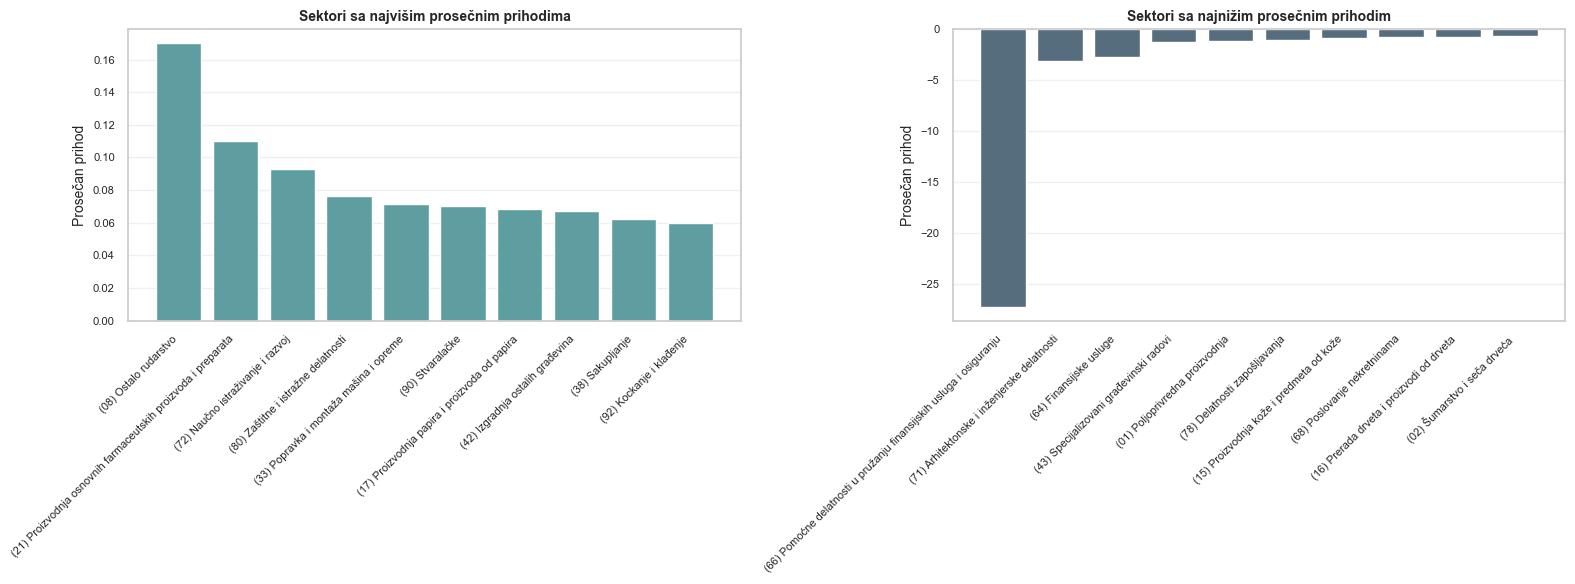

In [2709]:
top_nm_sectors = sektor_df.sort_values('neto_marza', ascending=False).head(10)
bottom_nm_sectors = sektor_df.sort_values('neto_marza', ascending=True).head(10)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_nm_sectors['opis'], top_nm_sectors['neto_marza'], color='#5F9EA0')
ax1.set_title('Sektori sa najvišim prosečnim prihodima', fontsize=10, fontweight='bold')
ax1.set_ylabel('Prosečan prihod', fontsize=10)
ax1.set_xticks(range(len(top_nm_sectors['opis'])))
ax1.set_xticklabels(top_nm_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_nm_sectors['opis'], bottom_nm_sectors['neto_marza'], color='#566D7E')
ax2.set_title('Sektori sa najnižim prosečnim prihodim', fontsize=10, fontweight='bold')
ax2.set_ylabel('Prosečan prihod', fontsize=10)
ax2.set_xticks(range(len(bottom_nm_sectors['opis'])))
ax2.set_xticklabels(bottom_nm_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.8. Sektori sa najvišom i najnižom amortizacijom

Prikazuje sektore sa najvišom i najnižom amortizacijom, koja se koristi kao pokazatelj kapitalno intenzivnog poslovanja. Za analizu je korišćena medijana, jer ona daje precizniji uvid u amortizaciju, posebno u slučajevima kada postoji veliki broj ekstremenih vrednosti koje mogu uticati na prosečan rezultat. Medijana omogućava realniji prikaz centralne tendencije, bez uticaja neobičnih vrednosti.

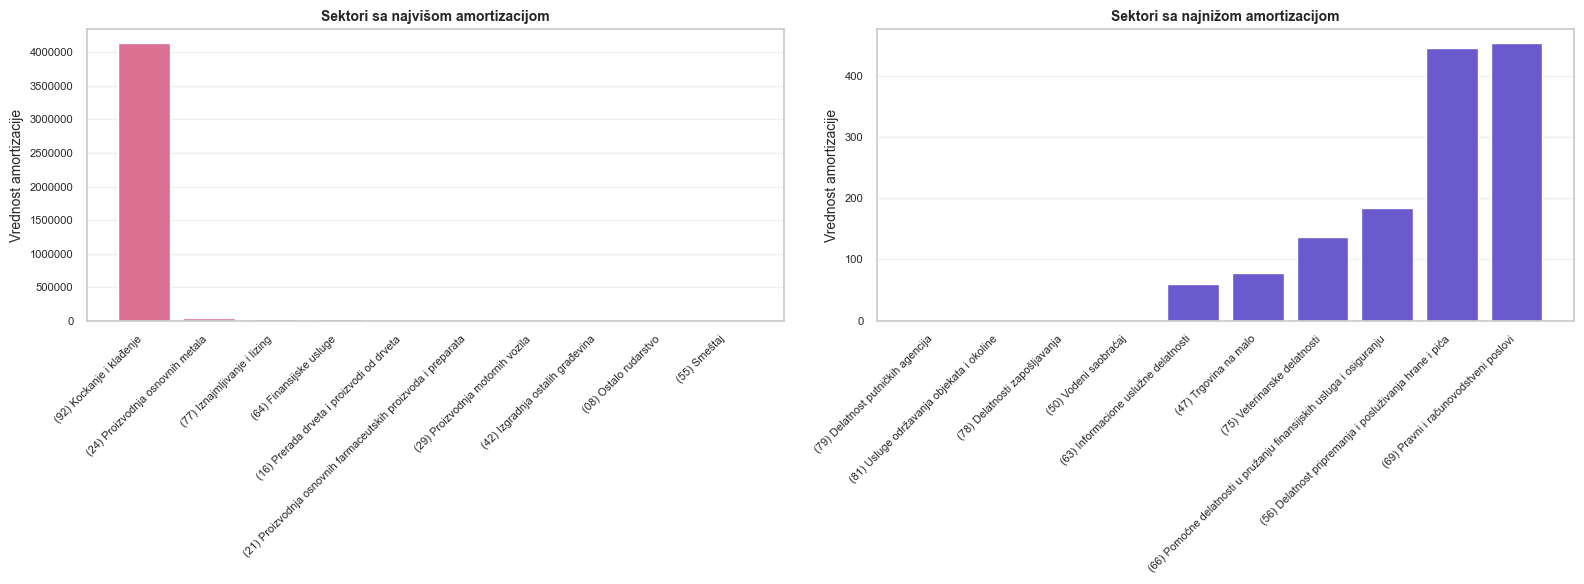

In [ ]:
top_amort_sectors = sektor_df.sort_values('amortizacija', ascending=False).head(10)
bottom_amort_sectors = sektor_df.sort_values('amortizacija', ascending=True).head(10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.bar(top_amort_sectors['opis'], top_amort_sectors['amortizacija'], color='PaleVioletRed')
ax1.set_title('Sektori sa najvišom amortizacijom', fontsize=10, fontweight='bold')
ax1.set_ylabel('Vrednost amortizacije', fontsize=10)
ax1.set_xticks(range(len(top_amort_sectors['opis'])))
ax1.set_xticklabels(top_amort_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid(False)
ax1.grid(axis='y', alpha=0.3)

ax2.bar(bottom_amort_sectors['opis'], bottom_amort_sectors['amortizacija'], color='SlateBlue')
ax2.set_title('Sektori sa najnižom amortizacijom', fontsize=10, fontweight='bold')
ax2.set_ylabel('Vrednost amortizacije', fontsize=10)
ax2.set_xticks(range(len(bottom_amort_sectors['opis'])))
ax2.set_xticklabels(bottom_amort_sectors['opis'], rotation=45, ha='right', fontsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.grid(False)
ax2.grid(axis='y', alpha=0.3)

ax1.ticklabel_format(style='plain', axis='y')
ax2.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()

4.B.9. Pregled informacija izabranog sektoru

Detaljan uvid u podatke o određenom sektoru na tržištu. Korišćenjem šifre sektora dobijaju se specifične informacije kao što su udeo prihoda, broj zaposlenih i broj kompanija koje pripadaju tom sektoru. Kroz vizualizaciju, prikazuju se komparativni podaci o tom sektoru u odnosu na celokupno tržište, kako bi se stekao bolji uvid u njegovu relativnu veličinu i značaj u ekonomiji. Analiza uključuje prikaz tržišnih udela u prihodima, broju zaposlenih i broju kompanija, kao i udelu neto marže sektora, što omogućava dublje razumevanje pozicije sektora i njegove efikasnosti.

Izbor sektora (unesi parcijalni naziv sektora)

In [ ]:
kriterijum_pretrage = 'prog'
# Unesi parcijalni deo naziva sektora za dobijanje šifre sektora


filtered_sektori = sektor_df[sektor_df['opis'].str.contains(kriterijum_pretrage, case=False, na=False)]

for sektor in filtered_sektori.iterrows():
    print(f"NAZIV SEKTORA: {sektor[1]['opis'].split(') ')[1]}, ŠIFRA SEKTORA: {sektor[1]['sektor']}")

NAZIV SEKTORA: Računarsko programiranje, ŠIFRA SEKTORA: 62
NAZIV SEKTORA: Programske aktivnosti i emitovanje, ŠIFRA SEKTORA: 60


Unos šifre izabranog sektora

In [ ]:
sifra_sektora = 62
# Unesi sifru sektora


sifra_sektora = str(sifra_sektora)
cond_sektor = False

if len(sifra_sektora) == 1:
    sifra_sektora = '0' + sifra_sektora

if sifra_sektora in sektor_df['sektor'].astype(str).values:
    cond_sektor = True
    print("Sektor je izabran, pokreni ostale ćelije za analizu sektora")
else:
    print("Ne postoji sektor sa ovom šifrom")

udeo_prihoda = 0
udeo_zaposlenih = 0
broj_kompanija_sektora = 0
broj_kompanija = 0

if cond_sektor:
    ukupni_prihod = df_analysis['prihod'].sum()
    prihod_sektora = sektor_df.loc[sektor_df['sektor'].astype(str) == sifra_sektora, 'ukupni_prihod'].values[0]
    udeo_prihoda = float(round(prihod_sektora / ukupni_prihod, 2))

    ukupni_zaposleni = df_analysis['broj_zaposlenih'].sum()
    zaposleni_sektora = sektor_df.loc[sektor_df['sektor'].astype(str) == sifra_sektora, 'broj_zaposlenih'].values[0]
    udeo_zaposlenih = float(round(zaposleni_sektora / ukupni_zaposleni, 2))

    broj_kompanija = df_analysis.shape[0]
    broj_kompanija_sektora = sektor_df.shape[0]

Sektor je izabran, pokreni ostale ćelije za analizu sektora


Udeo sektora na tržištu po prihodima, broju zaposlenih i broju kompanija

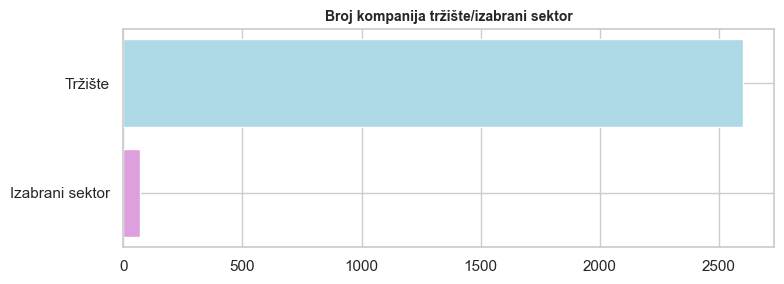

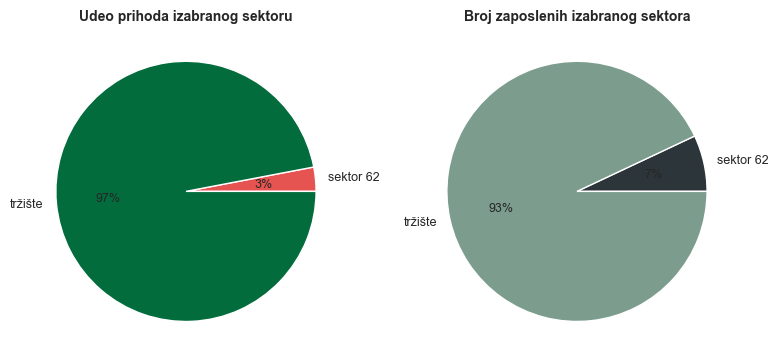

In [ ]:
if cond_sektor:

    plt.figure(figsize=(8, 3))
    plt.barh(['Izabrani sektor', 'Tržište'], [broj_kompanija_sektora, broj_kompanija], color=['#DDA0DD', '#ADD8E6'])
    plt.title('Broj kompanija tržište/izabrani sektor', fontsize=10, fontweight='bold')
    plt.tight_layout()
    plt.show()


    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].pie([udeo_prihoda, 1-udeo_prihoda], labels=[f'sektor {sifra_sektora}', 'tržište'], autopct='%1.0f%%', colors=['#E55451', '#026C3D'], textprops={'fontsize': 9})
    axs[0].set_title('Udeo prihoda izabranog sektoru', fontsize=10, fontweight='bold')

    axs[1].pie([udeo_zaposlenih, 1-udeo_zaposlenih], labels=[f'sektor {sifra_sektora}', 'tržište'], autopct='%1.0f%%', colors=['#2C3539', '#7C9D8E'], textprops={'fontsize': 9})
    axs[1].set_title('Broj zaposlenih izabranog sektora', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.show()
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")

Vrednost neto marže izabranog sektora

In [ ]:
if cond_sektor:
    print("OK")
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")

OK


Lista kompanija izabranog sektora

In [ ]:
if cond_sektor:
    print("OK")
else:
    print("Analiza sektora obustavljena, ne postoji sektor sa ovom šifrom")

OK


In [ ]:
### čišćenje memorije
del sektor_df

#### 4.A. PRIHODI

4.A.1. PRIHODI PREMA VELIČINI KOMPANIJE

Prihod se analizira u odnosu na veličinu kompanije kako bi se utvrdilo da li postoje značajne razlike u distribuciji prihoda između različitih kategorija veličine. Za procenu povezanosti koristi se jednofaktorska analiza varijanse (ANOVA), dok se raspodela vizualizuje putem box plotova.

Nulta hipoteza (H₀): Nema značajne razlike u prihodima između različitih kategorija veličine kompanija.

Alternativna hipoteza (H₁): Postoje značajne razlike u prihodima između različitih kategorija veličine kompanija.

In [ ]:
# # priprema podataka
# df_analysis['velicina_kod'] = df_features['velicina'].map({'Mikro': 0, 'Malo': 1, 'Srednje': 2, 'Veliko': 3})
# grupe = [grupa['prihod'].values for _, grupa in df_analysis.groupby('velicina_kod')]

# # # ANOVA test
# f_stat, p_value = f_oneway(*grupe)
# print(f"F-statistika: {f_stat:.2f}, p-vrednost: {p_value:.2f}")

# print()

# # Za utvrđivanje pravca povezanosti
# print(df_analysis.groupby('velicina_kod')['prihod'].mean())

In [ ]:
sns.boxplot(x='velicina_kod', y='prihod', data=df_analysis)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('PRIHODI PREMA VELIČINI KOMPANIJE', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

ValueError: Could not interpret value `velicina_kod` for `x`. An entry with this name does not appear in `data`.

Zaključak

Na osnovu ANOVA testa, rezultati pokazuju da postoji značajna razlika u prihodima između različitih veličina kompanija (F-statistika: 1426.43, p-vrednost: 0.0). S obzirom na vrlo malu p-vrednost (manju od 0.05), odbacujemo nultu hipotezu (H₀) i prihvatamo alternativnu hipotezu (H₁), što znači da postoji statistički značajna razlika u prihodima između kompanija različitih veličina.

Dodatno, analiza prosečnih prihoda prema veličini kompanije ukazuje da se sa povećanjem veličine kompanije povećavaju i prihodi. Ovo potvrđuje da veće kompanije ostvaruju značajno veće prihode u poređenju sa manjim kompanijama.

4.A.2. PRIHODI PREMA BROJU ZAPOSLENIH

Prihod se analizira u odnosu na broj zaposlenih kako bi se utvrdilo postoji li povezanost između broja zaposlenih i visine prihoda kompanije. Za ovu analizu koristi se linearna regresija, koja testira da li postoji linearan odnos između ove dve varijable. Uz regresiju, biće korišćen i scatter plot za vizualizaciju odnosa između broja zaposlenih i prihoda. Ukoliko se pokaže značajna povezanost, biće moguće doneti zaključke o tome kako promene u broju zaposlenih utiču na prihode.

Nulta hipoteza (H₀): Nema linearne povezanosti između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

In [ ]:
lr_model = LinearRegression()

# Treniranje modela
lr_model.fit(df_analysis[['broj_zaposlenih']], df_analysis['prihod'])

# Predikcija
predicted = lr_model.predict(df_analysis[['broj_zaposlenih']])

# Prikazivanje koeficijenata
print(f'Koeficijent: {lr_model.coef_[0]:.2f}')
print(f'Intercept: {lr_model.intercept_:.2f}')

Koeficijent: 97241.51
Intercept: 516764.15


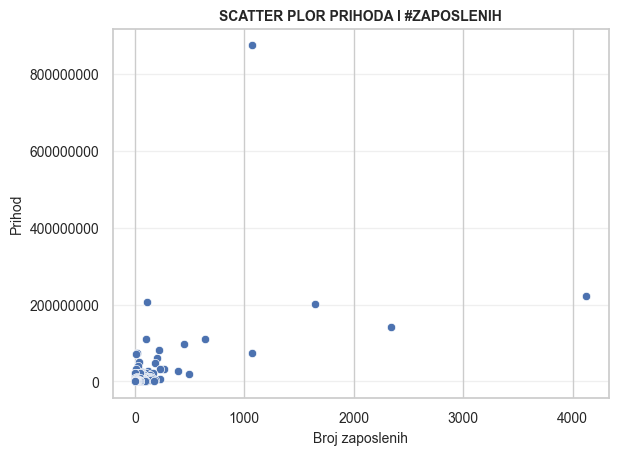

In [ ]:
sns.scatterplot(x='broj_zaposlenih', y='prihod', data=df_analysis)

plt.xlabel('Broj zaposlenih', fontsize=10)
plt.ylabel('Prihod', fontsize=10)
plt.title('SCATTER PLOR PRIHODA I #ZAPOSLENIH', fontsize=10, fontweight='bold')

plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.get_major_formatter().set_scientific(False)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

Zaključak

Na osnovu rezultata linearne regresije, koeficijent od 122,246.73 ukazuje na to da za svaki dodatni zaposleni, prihod raste za približno 122,246.73 jedinica. Intercept od 79,039.23 označava očekivani prihod u slučaju kada broj zaposlenih iznosi nula. Sa pozitivnim koeficijentom, ovo sugeriše postojanje pozitivne linearne povezanosti između broja zaposlenih i prihoda kompanije.

S obzirom na ove rezultate, može se zaključiti da veći broj zaposlenih ima pozitivan uticaj na prihod kompanije, odnosno, kako broj zaposlenih raste, prihod takođe raste.

Nulta hipoteza (H₀): Ne postoji linearna povezanost između broja zaposlenih i prihoda.

Alternativna hipoteza (H₁): Postoji linearna povezanost između broja zaposlenih i prihoda.

Na osnovu analize, možemo odbaciti nultu hipotezu i prihvatiti alternativnu hipotezu, što znači da postoji statistički značajna linearna povezanost između broja zaposlenih i prihoda.

4.A.3. IDENTIFIKACIJA SEKTORA SA NAJNIŽIM I NAJVIŠIM PRIHODIMA

U ovoj analizi posmatra se raspodela prihoda po različitim vrstama sektora poslovanja kako bi se identifikovali sektori sa najvećim i najmanjim prihodima.

In [ ]:
# print('SEKTORI SA NAJVEÇIM PRIHODIMA:')
# print()

# top5_sektora = (
#     df_analysis.groupby('sektor')['prihod']
#     .mean()
#     .sort_values(ascending=False)
#     .head(5)
#     .reset_index()
# )
# company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

# top5_sektora = top5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
# top5_sektora = top5_sektora.merge(company_count, on='sektor', how='left')

# top5_sorted = top5_sektora.sort_values(by='prihod', ascending=False)

# for i, row in top5_sorted.iterrows():
#     print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
#           f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
#           f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJVEÇIM PRIHODIMA:

- Sektor 92 (Kockanje i klađenje):
  Prosečan prihod: 37444141.0
  Broj kompanija: 2

- Sektor 09 (Uslužne delatnosti u rudarstvu i geološkim istraživanjima):
  Prosečan prihod: 34258171.8
  Broj kompanija: 5

- Sektor 27 (Proizvodnja električne opreme):
  Prosečan prihod: 28702296.12
  Broj kompanija: 8

- Sektor 32 (Ostale prerađivačke delatnosti):
  Prosečan prihod: 12812460.67
  Broj kompanija: 9

- Sektor 10 (Proizvodnja prehrambenih proizvoda):
  Prosečan prihod: 8854331.41
  Broj kompanija: 34



In [ ]:
# print('SEKTORI SA NAJMANJIM PRIHODIMA:')
# print()

# bottom5_sektora = (
#     df_analysis.groupby('sektor')['prihod']
#     .mean()
#     .sort_values(ascending=False)
#     .tail(5)
#     .reset_index()
# )

# company_count = df_analysis.groupby('sektor')['prihod'].count().reset_index(name='company_count')

# bottom5_sektora = bottom5_sektora.merge(delatnosti_df, left_on='sektor', right_on='sifra', how='left')
# bottom5_sektora = bottom5_sektora.merge(company_count, on='sektor', how='left')

# top5_sorted = bottom5_sektora.sort_values(by='prihod', ascending=True)

# for i, row in top5_sorted.iterrows():
#     print(f"- Sektor {row['sektor']} ({row['opis']}):\n"
#           f"  Prosečan prihod: {round(row['prihod'], 2)}\n"
#           f"  Broj kompanija: {row['company_count']}\n")

SEKTORI SA NAJMANJIM PRIHODIMA:

- Sektor 03 (Ribarstvo i akvakulture):
  Prosečan prihod: 15596.0
  Broj kompanija: 1

- Sektor 30 (Proizvodnja ostalih saobraćajnih sredstava):
  Prosečan prihod: 21650.5
  Broj kompanija: 2

- Sektor 15 (Proizvodnja kože i predmeta od kože):
  Prosečan prihod: 25424.0
  Broj kompanija: 1

- Sektor 88 (Socijalna zaštita bez smeštaja):
  Prosečan prihod: 34084.5
  Broj kompanija: 2

- Sektor 50 (Vodeni saobraćaj):
  Prosečan prihod: 67175.0
  Broj kompanija: 2



4.A.4. PROSEČNI PRIHODI PO ZAPOSLENOM PREMA SEKTORU POSLOVANJA



----------------- NE VALJA STARII TEKST -----------------
Poređenje broja zaposlenih prema delatnosti poslovanja omogućava analizu veze između broja radnika i specifičnosti industrije.
Hipoteza: Sektori sa većim obimom poslovanja ili specifičnim potrebama često zahtevaju veći broj zaposlenih, dok manji ili efikasniji sektori mogu operisati sa manjim brojem radnika.
Ovaj pregled pomaže u identifikaciji obrazaca zapošljavanja unutar različitih industrija i može biti koristan za procenu resursnih potreba po sektorima.

In [ ]:
# bottom5_sektora

,sektor,prihod,sifra,opis,company_count
0,50,"67,175.00",50,Vodeni saobraćaj,2
1,88,"34,084.50",88,Socijalna zaštita bez smeštaja,2
2,15,"25,424.00",15,Proizvodnja kože i predmeta od kože,1
3,30,"21,650.50",30,Proizvodnja ostalih saobraćajnih sredstava,2
4,03,"15,596.00",03,Ribarstvo i akvakulture,1


4.A.5. Analiza izolovanih slučajeva (outlier amaliza)

#### 4.B. Rashodi

4.B.1. Sektori i industrije sa najvišim i najnižim operativnim rashodima.

#### 4.C. Neto dobit


4.C.1. Najprofitabilnije i najmanje profitabilni sektori i industrije.


4.C.2. Neto dobit i broj zaposlenih. -- da li je optimalna utilitizacija zaposlenih u konververziji prihoda u neto dobit


4.C.D. Povezanost boniteta i neto dobiti kompanija.

4.C.5. Analiza izolovanih slučajeva (outlier): kompanije sa ekstremno visokim prihodom, ali niskom neto maržom.

#### 4.D. Amortizacija kao pokazatelj kapitalnih investiranja

4.D.1. Analiza povezanosti vrednosti amortizacije i prihoda, po sektoru, veličini i bonitetu

4.D.2. Prossečan neto povraćaj na kapitalna ulaganja.

4.D.3. Prosečna kapitalna ulaganja po zaposlenom po sektoru poslovanja.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja.

4.E.5. Marža kamate i poreza. veličina i sektor poslovanja.

#### 4.F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.E.4. Marža amortizacije: veličina, bonitet, sektor poslovanja

#### F. Zaposleni

4.F.1. Prosečan broj zaposlenih prema industriji i sektoru poslovanja.

4.F.2. Test normalne distribucije zaposlenih po prihodima.

4.F.3. Prosečan broj zaposlenih prema bonitetnom skoru.

4.F.4. Prosečan broj zaposlenih prema dekadi osnivanja.

#### G. Ostalo

4.G.1. NUMERIČKI PRIKAZ KOMPANIJA PREMA VELIČINI

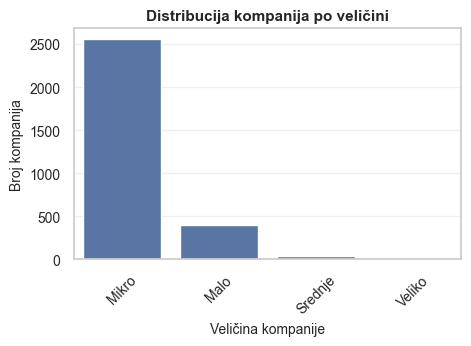

In [ ]:
plt.figure(figsize=(5, 3))
sns.countplot(data=df_analysis, x='velicina', order=df_analysis['velicina'].value_counts().index)

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po veličini', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)

plt.show()

4.G.2. NUMERIČKI PRIKAZ KOMPANIJA PO BONITETNOJ OCENI

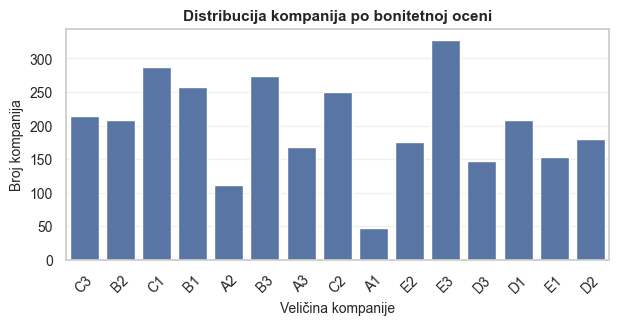

In [ ]:
plt.figure(figsize=(7, 3))
sns.countplot(data=df_analysis, x='bonitet')

plt.xlabel('Veličina kompanije', fontsize=10)
plt.ylabel('Broj kompanija', fontsize=10)
plt.title('Distribucija kompanija po bonitetnoj oceni', fontsize=11, fontweight='bold')
plt.xticks(rotation=45)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', alpha=0.3)
plt.show()

4.G.3. Najzastupljeniji sektori i industrije novosadskih kompanija.

In [ ]:
most_common_sectors = (
    df_analysis['sektor'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'sektor'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='sektor', right_on='sifra', how='left')
)

most_common_sectors['opis'] = most_common_sectors['opis'].str.split('[,;]').str[0]
most_common_sectors.drop(columns=['sifra', 'sektor'], inplace=True)

df_analysis['industrija'] = df_analysis['industrija'].astype(str)
most_common_industries = (
    df_analysis['industrija'].value_counts()
    .head(10)
    .reset_index(name='broj_kompanija')
    .rename(columns={'index': 'industrija'})
    .merge(delatnosti_df[['sifra', 'opis']], left_on='industrija', right_on='sifra', how='left')
)

most_common_industries['opis'] = most_common_industries['opis'].str.extract(r'^(.{0,40}(?:\s|$))')[0].str.strip()
most_common_industries.drop(columns=['sifra'], inplace=True)

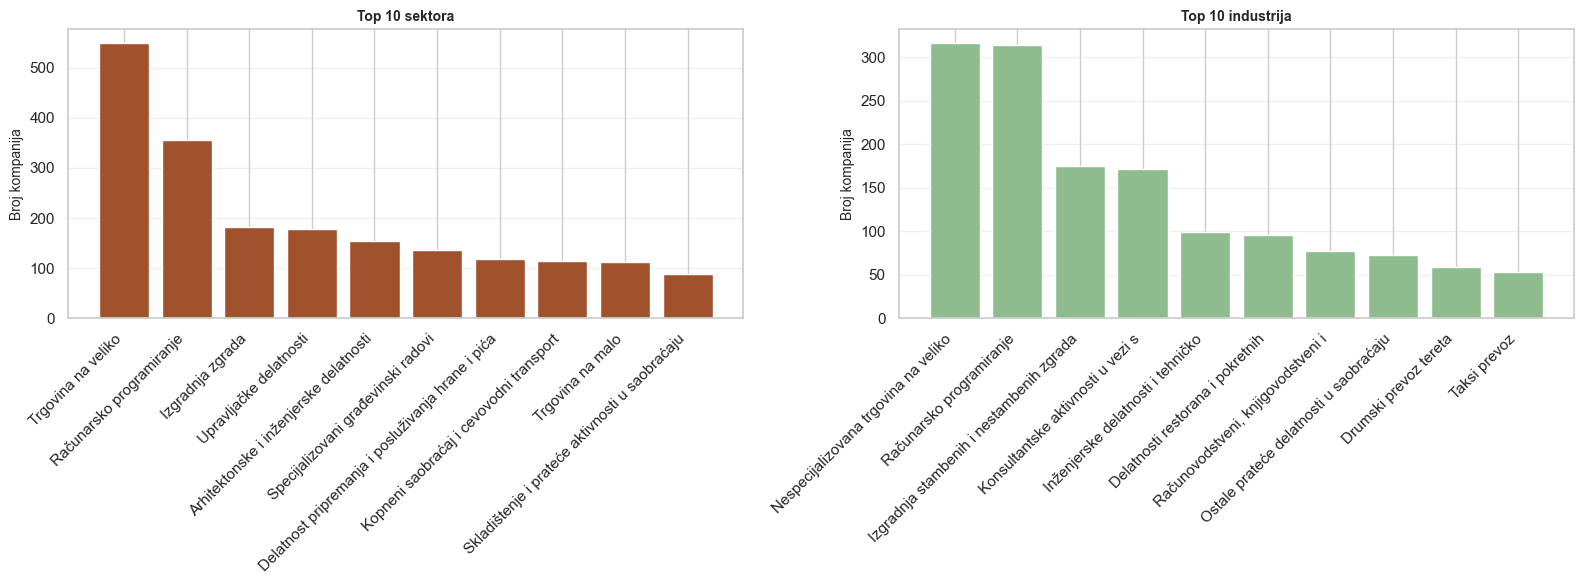

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# Sektori
ax1.bar(most_common_sectors['opis'], most_common_sectors['broj_kompanija'], color='Sienna')
ax1.set_title('Top 10 sektora', fontsize=10, fontweight='bold')
ax1.set_ylabel('Broj kompanija', fontsize=10)
ax1.set_xticks(range(len(most_common_sectors)))
ax1.set_xticklabels(most_common_sectors['opis'], rotation=45, ha='right')
ax1.grid(axis='y', alpha=0.3)

# Industrije
ax2.bar(most_common_industries['opis'], most_common_industries['broj_kompanija'], color='DarkSeaGreen')
ax2.set_title('Top 10 industrija', fontsize=10, fontweight='bold')
ax2.set_ylabel('Broj kompanija', fontsize=10)
ax2.set_xticks(range(len(most_common_industries)))
ax2.set_xticklabels(most_common_industries['opis'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
trend_df = df_analysis.groupby('dekada_osnivanja').agg({
    'prihod': 'mean',
    'neto_dobit': 'mean',
    'broj_zaposlenih': 'mean',
    'ebit': 'mean',
    'ebitda': 'mean',
    'operativni_rashodi': 'mean',
    'amortizacija': 'mean',
    'net_marza': 'mean',
    'ebit_marza': 'mean',
    'ebitda_marza': 'mean',
    'marza_amortizacije': 'mean',
    'marza_kamate_poreza': 'mean'
}).reset_index()

KeyError: 'dekada_osnivanja'

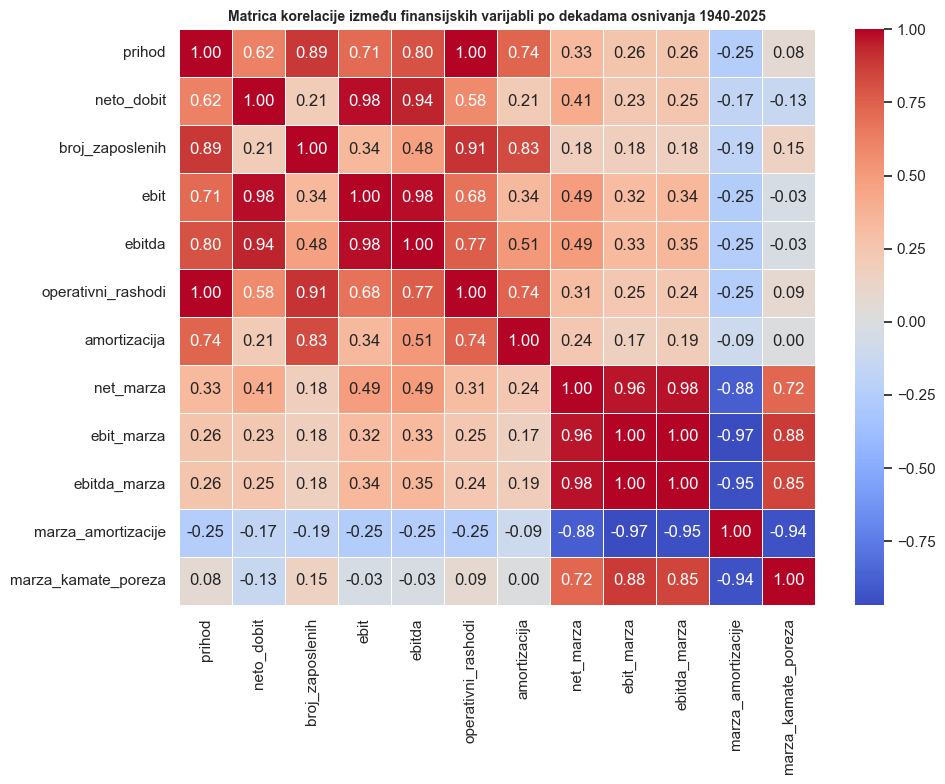

In [ ]:
correlation_matrix = trend_df.drop(columns=['dekada_osnivanja']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Matrica korelacije između finansijskih varijabli po dekadama osnivanja 1940-2025', fontsize=10, fontweight='bold')
plt.tight_layout()

plt.show()

Vizuelizacija prihoda i broja zaposlenih po dekadama

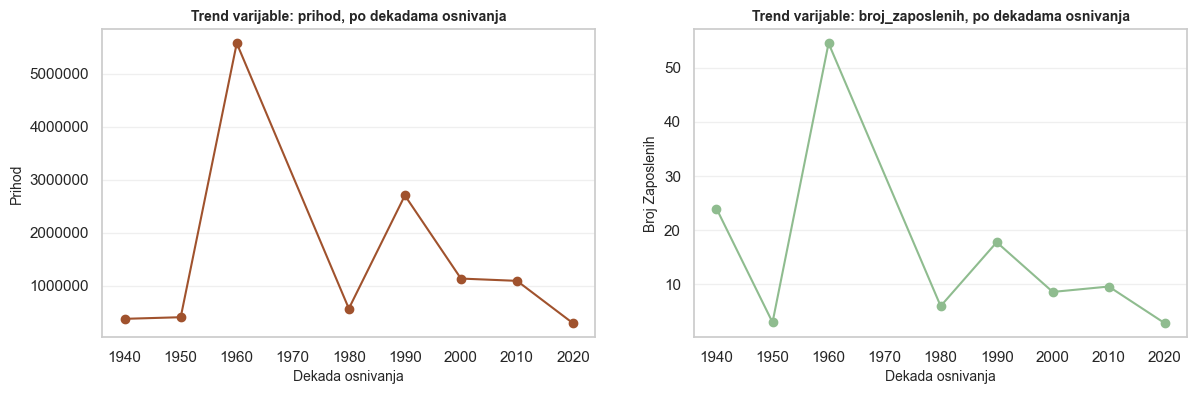

In [ ]:
var_1 = 'prihod'
var_2 = 'broj_zaposlenih'

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(trend_df['dekada_osnivanja'], trend_df[var_1], marker='o', color='Sienna')
axes[0].set_title(f'Trend varijable: {var_1}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[0].yaxis.set_major_formatter(ScalarFormatter())
axes[0].yaxis.get_major_formatter().set_scientific(False)

axes[0].set_xlabel('Dekada osnivanja', fontsize=10)
axes[0].set_ylabel('Prihod', fontsize=10)

axes[0].grid(False) 
axes[0].grid(True, axis='y', alpha=0.3) 

# Broja zaposlenih po dekadama osnivanja
axes[1].plot(trend_df['dekada_osnivanja'], trend_df[var_2], marker='o', color='DarkSeaGreen')
axes[1].set_title(F'Trend varijable: {var_2}, po dekadama osnivanja', fontsize=10, fontweight='bold')

axes[1].set_xlabel('Dekada osnivanja', fontsize=10)
axes[1].set_ylabel('Broj Zaposlenih', fontsize=10)

axes[1].grid(False)  
axes[1].grid(True, axis='y', alpha=0.3) 

plt.show()


### 5. ANALIZA SEKTORA IZ GRUPE NAJPROFITABILNIJIH

Pre izbora sektora na kojem će biti primenjeni analitički postupci, neophodno je filtrirati podatke za primenu tih postupaka.

FILTRIRANJE

Filtiranje podataka biće postignuto isključenjem velikih kompanija sa nesrazmernim uticajem na ukupne finansijske pokazatelje, eliminacijom kompanija sa 0 zaposlenih i isključenjem ekstremnih vrednosti u broju zaposlenih, pod uslovom da njihov prihod nije značajan za skup podataka, kako bi se očuvala reprezentativnost uzorka.

FILTRIRANJE I UKLANJANJE EKSTREMNIH VREDNOSTI IZ SKUPA
- Brisanje velikih kompanija
- Brisanje kompanija sa 0-1 zaposlenih i kompanija sa velikim brojem zaposlenih, ukoliko je to prihvatljivo
- Uklanjanje ekstremnih vrednosti kroz Z-score metodologiju (prihodi i zaposleni)

#### IZBOR SEKTORA ZA ANALIZU

S obzirom na heterogenost skupa podataka, segmentacija po sektorima omogućava validniju i smisleniju analizu. 

Za dalju analizu odabrana je delatnost **trgovine na veliko**, s obzirom na njenu stabilnost, značajan udeo u lokalnoj privredi i relativno homogenu strukturu poslovanja. Ovaj sektor ima veliki broj aktivnih firmi sa pouzdanim i uporedivim finansijskim pokazateljima, što omogućava validniju analizu i relevantnije zaključke.


In [ ]:
df_segment = df_features.copy()

In [ ]:
df_segment.drop(columns='godina_osnivanja', inplace=True)

In [ ]:
df_segment = df_segment[df_segment['velicina'] != 'Veliko']

In [ ]:
ukupan_prihod = df_segment['prihod'].sum()

prihod_0_zaposlenih = df_segment[df_segment['broj_zaposlenih'] == 0]['prihod'].sum()
udeo_zaposleni_lower = prihod_0_zaposlenih / ukupan_prihod * 100

print(f"Udeo prihoda kompanija sa 0 zaposlenih je: {udeo_zaposleni_lower:.2f}%") 

prihod_iznad_200_zaposlenih = df_segment[df_segment['broj_zaposlenih'] > 200]['prihod'].sum()
udeo_zaposleni_upper = prihod_iznad_200_zaposlenih / ukupan_prihod * 100

print(f"Udeo prihoda kompanija sa više od 200 zaposlenih je: {udeo_zaposleni_upper:.2f}%")

Donji i gornji ekstremi kompanija u smislu broja zaposlenih će biti isključeni iz skupa je mogu narušiti reprezentativnost uzorka, a testiranje njihovog učešća u ukupnih prihodima čini ovo isključenje analitički prihvatljivim.

U sledećem koraku proveravamo exkstremne vrednosti direktno na prihodima primenom z-skor metode.

In [ ]:
df_segment = df_segment[df_segment['broj_zaposlenih'] != 0]

df_segment = df_segment[df_segment['broj_zaposlenih'] < 200]

Z-SKOR filtriranje

In [ ]:
ukupan_prihod = df_segment['prihod'].sum()

df_segment['zscore_prihod'] = zscore(df_segment['prihod'])

prihod_outliers = df_segment[df_segment['zscore_prihod'].abs() > 3]

prihod_outliers = prihod_outliers['prihod'].sum() / ukupan_prihod * 100

print(f"Udeo prihoda outliera u ukupnim prihodima je: {prihod_outliers:.2f}%")

Zaključak o eliminaciji ekstremnih vrednosti

Na osnovu testiranja Z-skor metodologije, utvrđeno je da primenom standardne vrednosti Z-skor praga od 3, koja eliminiše ekstremne vrednosti, bi se eliminisalo oko 33.50% kompanija po prihodima. Ovo ukazuje da su prema kriterijumu prihoda ekstremne vrednosti već eliminisane, stoga dalji postupci eliminacije ekstrema neće biti sprovedeni.

#### H. Klaster analiza.

Priprema i enkodiranje podataka